In [1]:
import torch 
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
class Data():
    def __init__(self, filename):
        data = pd.read_pickle(filename)
        d_time = data.drop(columns=['X'])
        d_pos  = data.drop(columns=['T'])
        x = d_time.iloc[:, :].values
        y =  d_pos.iloc[:, :].values

        self.x = torch.tensor(x, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.float)

    def __len__(self):
        return len(self.x)
    
    def __getparams__(self):
        return self.x, self.y

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


data = Data('training-oha.pkl')  
vdata = Data('validation-oha.pkl') 
#data.__getparams__()

In [3]:
class OHAModel(nn.Module):
    def __init__(self):
        super(OHAModel, self).__init__()
        self.linear = nn.Sequential(nn.Linear(1, 32), nn.Sigmoid(), nn.Linear(32, 1)) # 1 InputL, 32 HiddenL, 1 OutputL

    def forward(self, x):
        out = self.linear(x)
        return out

model = OHAModel()
print(model)

OHAModel(
  (linear): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [4]:
optimiser = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss()

In [5]:
epochs = 200000
x_train = data.x
y_train = data.y

for epoch in range(epochs):
    epoch+=1
    inputs = x_train
    desired_outputs = y_train

    out = model(inputs)
    optimiser.zero_grad()
    
    loss = loss_func(out, desired_outputs)
    loss.backward()

    optimiser.step()
    #print(f'Epoch {epoch}, loss {loss.item()}', flush=True)


In [6]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


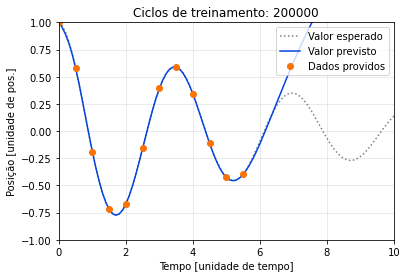

In [7]:
model = OHAModel()
model.load_state_dict(torch.load("model.pth"))

predicted = model.forward(vdata.x)
vx = vdata.x.detach().numpy()
vy = vdata.y.detach().numpy()

x = data.x.detach().numpy()
y = data.y.detach().numpy()

plt.plot(vx, vy, color='tab:gray', linestyle=':', label='Valor esperado')
plt.plot(vx, predicted.detach().numpy(), color='xkcd:blue', linestyle='solid', label = 'Valor previsto')
plt.plot(x, y, color='xkcd:orange', marker='o', linestyle='none', label = 'Dados providos')
plt.xlim([0, 10])
plt.ylim([-1, 1])
plt.title(f'Ciclos de treinamento: {epochs}')
plt.xlabel('Tempo [unidade de tempo]')
plt.ylabel('Posição [unidade de pos.]')
plt.legend(loc=1) # 4 = 'lower right'
plt.grid(True, alpha=0.3)
plt.savefig('grafico-oha.jpg', dpi=150)
plt.show()